In [33]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/projects/my_dshark/py_dshark'))
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/projects/electron_drifts/extended_python'))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import py_dshark
import pickle
import glob
from extended_util import (kaw_disp_k_space_search,
                           kaw_disp_k_space_interval_search,
                           save_disp_data, 
                           process_stage_1_data, 
                           disp_fix_angle_search,
                           disp_fix_angle_interval_search,
                           kaw_disp_fixed_k_search,
                           kaw_disp_core_drift_search
                          )
import multiprocessing as mp
from scipy import interpolate
import time

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
mpl.rcParams['legend.fontsize'] = 14
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def fast_freq(kdi, theta):
    return kdi * np.sqrt(1 + kdi**2 * np.cos(np.deg2rad(theta))**2)

def whistler_freq(kdi, theta):
    return 1836 * kdi**2 / (1836 + kdi**2) * np.cos(np.deg2rad(theta))

p_global = {}
p_global['nspecies_in'] = 3
p_global['q_in'] = np.array([1., -1., -1.])
p_global['mu_in'] = np.array([1., 1836., 1836.])
p_global['dens_in'] = np.array([1., .95, .05])
vdc_va = 0
p_global['drift_in'] = np.array([0., vdc_va, -p_global['dens_in'][1]/p_global['dens_in'][2]* vdc_va])
t_in = np.array([1, 1, 10])
beta_0 = 0.04
anisotropy = np.array([1, 1, 1])
p_global['beta_para_in'] = beta_0 * t_in * p_global['dens_in']
p_global['beta_perp_in'] = beta_0 * t_in * p_global['dens_in'] * anisotropy
p_global['kappa_in'] = np.array([50, 50, 50])
p_global['delta_in'] = 1e-4
p_global['increment_r'] = 0
p_global['increment_i'] = 0
p_global['rf_error_in'] = 1e-4
p_global['eps_error_in'] = 1e-6
p_global['omega_r_range'] = [0, 2000]
p_global['omega_i_range'] = [-2000, 2000]
p_global['omega_i_omega_r_range'] = 1.
p_global['parallel_mode_in'] = 0

In [19]:
k_intervals=[1, 5, 20]
nks=[20, 30]
theta = 0
# init_guess = 1.4 - 0.9j
init_guess = fast_freq(k_intervals[0], theta) * (1 + p_global['drift_in'][0]) 
# init_guess = whistler_freq(k_intervals[0], theta) * (1 + p_global['drift_in'][0])
print('guess={0:.3g}'.format(init_guess))
k_range, disp = disp_fix_angle_interval_search(p_global, theta, init_guess, k_intervals=k_intervals, nks=nks)
print('found: {0:.3g}'.format(disp[0]))

guess=1.41
found: 1.62-6.05e-11j


In [15]:
k_intervals=[1, 5, 20, 45]
nks=[20, 30, 25]
theta = 0
init_guess = fast_freq(k_intervals[0], theta) * (1 + p_global['drift_in'][0]) 
result = {}
for kappa in [4, 8, 50]:
    print('guess={0:.3g}'.format(init_guess))
    p = p_global.copy()
    p['kappa_in'] = [50, 50, kappa]
    k_range, disp = disp_fix_angle_interval_search(p, theta, init_guess, k_intervals=k_intervals, nks=nks)
    print('found: {0:.3g}'.format(disp[0]))
    result[kappa] = (k_range, disp)
    

guess=1.41
found: 1.6+1.86e-12j
guess=1.41
found: 1.6-9.56e-12j
guess=1.41
found: 1.6-7.06e-12j


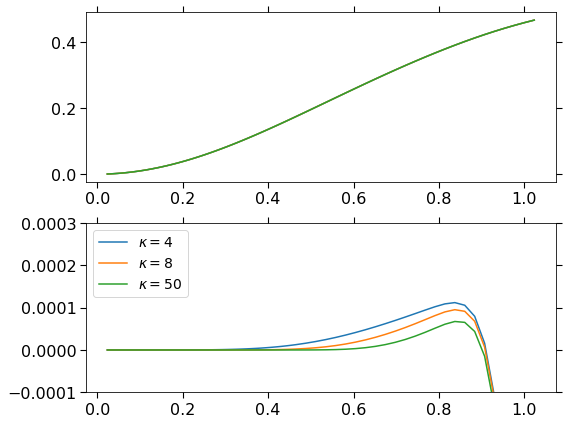

In [23]:
plt.figure(figsize=[8, 6])
plt.subplot(211)
for kappa in [4, 8, 50]:
    k_range, disp = result[kappa]
    plt.plot(k_range/43, disp.real/1836, '-', label=f'$\kappa=${kappa}')

plt.subplot(212)
for kappa in [4, 8, 50]:
    k_range, disp = result[kappa]
    plt.plot(k_range/43, disp.imag/1836, '-', label=f'$\kappa=${kappa}')
plt.legend(loc='upper left')
plt.ylim([-1e-4, 3e-4])
plt.tight_layout()
plt.show()

In [24]:
k_intervals=[1, 5, 20, 45]
nks=[20, 30, 25]
theta = 0
p = p_global.copy()
p['drift_in'] = [0, 0, 0]
init_guess = fast_freq(k_intervals[0], theta) 
print('guess={0:.3g}'.format(init_guess))
k_range, disp = disp_fix_angle_interval_search(p, theta, init_guess, k_intervals=k_intervals, nks=nks)
print('found: {0:.3g}'.format(disp[0]))

guess=1.41
found: 1.62-6.05e-11j


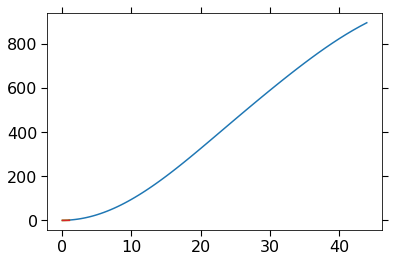

In [26]:
plt.plot(k_range, disp.real)
for kappa in [4, 8, 50]:
    k_range, disp = result[kappa]
    plt.plot(k_range/43, disp.real/1836, '-', label=f'$\kappa=${kappa}')

In [28]:
k_range

array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
        3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 21. , 22. , 23. , 24. ,
       25. , 26. , 27. , 28. , 29. , 30. , 31. , 32. , 33. , 34. , 35. ,
       36. , 37. , 38. , 39. , 40. , 41. , 42. , 43. , 44. ])